In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [3]:

# see how many images are there for each digit
for j in np.arange(10):
    idx = np.where(y==str(j))
    idx = np.asarray(idx)[0,:]
    print('digit %i length %i' % (j, len(idx)))

digit 0 length 6903
digit 1 length 7877
digit 2 length 6990
digit 3 length 7141
digit 4 length 6824
digit 5 length 6313
digit 6 length 6876
digit 7 length 7293
digit 8 length 6825
digit 9 length 6958


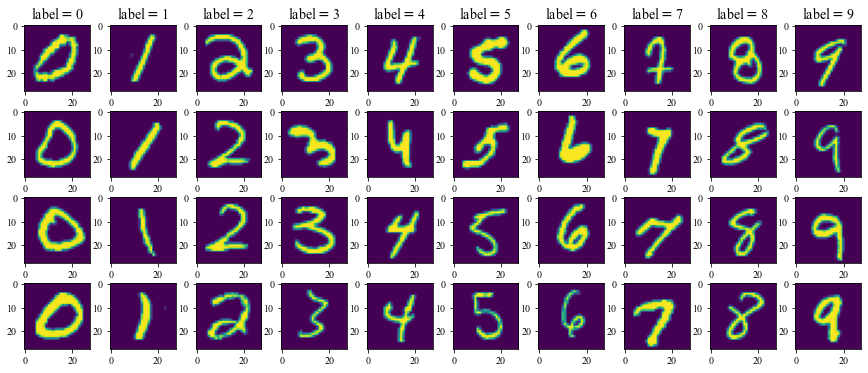

In [4]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        idx = np.where(y==str(j)) # index of all images of digit 'j'
        idx = np.asarray(idx)[0,:] # make idx from tuple to array
        idx_subsampled = np.random.choice(idx, nrows)
        ax[i,j].imshow(X[idx_subsampled[i],:].reshape(28,28))
        # ax[i,j].title.set_text("label=%s" % y[idx_subsampled[j]]) 
        if i == 0:
            # ax[j,i].set_ylabel("label=%s" % y[idx_subsampled[j]]) 
            ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('MNIST_ex1.pdf', bbox_inches='tight')

In [5]:

# Split the dataset into train and test sets

X_train = []
X_test = []
y_test = []
y_train = []
for i in np.arange(X.shape[0]):
    # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
    U = np.random.rand() # Uniform([0,1]) variable
    if U<0.8:
        X_train.append(X[i,:])
        y_train.append(y[i])
    else:
        X_test.append(X[i,:])
        y_test.append(y[i])
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (56096, 784)
X_test.shape (13904, 784)
y_train.shape (56096,)
y_test.shape (13904,)


In [6]:
def sample_binary_MNIST(list_digits=['0','1'], full_MNIST=None):
    # get train and test set from MNIST of given two digits
    # e.g., list_digits = ['0', '1']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.

    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = y[idx]

    X_train = []
    X_test = []
    y_test = [] # list of integers 0 and 1s
    y_train = [] # list of integers 0 and 1s
    
    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        label = 0
        if y01[i] == str(list_digits[1]):
            label = 1

        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(label)
        else:
            X_test.append(X01[i,:])
            y_test.append(label)

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train).reshape(-1,1)
    y_test = np.asarray(y_test).reshape(-1,1)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test, sample_binary_MNIST(list_digits=['0','1'], full_MNIST=[X, y])
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (56096, 784)
X_test.shape (13904, 784)
y_train.shape (56096,)
y_test.shape (13904,)


In [7]:
# sigmoid and logit function 
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

In [8]:
def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))

In [9]:
def fit_LR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1)
            
        W1 = W0.copy()
        i = 0
        dist = 1
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            loss = 0
            j=0
            for j in np.arange(Y.shape[0]):   
                if H[:,j].T @ W1 > 100:
                    loss = H[:,j].T @ W1  + loss
                else:
                    loss = np.log(1+np.exp(H[:,j].T @ W1 )) + loss
            loss = loss - (Y.T@ H.T @W1)
            loss = loss[0,0]
            loss_list = np.append(loss_list, loss)
            print('iter %i, loss %f' %(i, loss))
        return W1,loss_list

In [10]:
X_train, X_test, y_train, y_test = sample_binary_MNIST(['0', '1'], full_MNIST = [X,y])
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))

W1,loss_1 = fit_LR_GD(Y=y_train, H=H_train,sub_iter=50) 

iter 1, loss 377572.656555
iter 2, loss 352833988.149067


<ipython-input-9-8993141f2a08>:11: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))


iter 3, loss 746870.173536
iter 4, loss 735232.405069
iter 5, loss 723362.382640
iter 6, loss 711503.591933
iter 7, loss 700390.417262
iter 8, loss 689641.479426
iter 9, loss 679498.707774
iter 10, loss 669415.400974
iter 11, loss 659868.962391
iter 12, loss 651093.050406
iter 13, loss 643231.163240
iter 14, loss 636160.755773
iter 15, loss 629651.308945
iter 16, loss 623363.749233
iter 17, loss 617202.248399
iter 18, loss 611564.969467
iter 19, loss 606195.663266
iter 20, loss 600871.143861
iter 21, loss 595590.316799
iter 22, loss 590352.068955
iter 23, loss 585155.286946
iter 24, loss 579998.869823
iter 25, loss 575024.060904
iter 26, loss 570549.618271
iter 27, loss 566573.521620
iter 28, loss 562654.526648
iter 29, loss 559062.638296
iter 30, loss 555495.568120
iter 31, loss 552056.150058
iter 32, loss 548709.417056
iter 33, loss 545384.520854
iter 34, loss 542080.917923
iter 35, loss 538798.085670
iter 36, loss 535535.521641
iter 37, loss 532375.794749
iter 38, loss 529364.635010

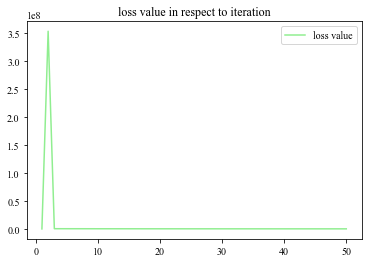

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1)
x = np.linspace(1, 50, 50)
ax.plot(x, loss_1, color='lightgreen', label="loss value")
ax.title.set_text("loss value in respect to iteration")
ax.legend()

In [12]:
def fit_LR_GD_2(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1)
            
        W1 = W0.copy()
        i = 0
        dist = 1
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (10*np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            loss = 0
            j=0
            for j in np.arange(Y.shape[0]):   
                if H[:,j].T @ W1 > 100:
                    loss = H[:,j].T @ W1  + loss
                else:
                    loss = np.log(1+np.exp(H[:,j].T @ W1 )) + loss
            loss = loss - (Y.T@ H.T @W1)
            loss = loss[0,0]
            loss_list = np.append(loss_list, loss)
            print('iter %i, loss %f' %(i, loss))
        return W1,loss_list

In [13]:
X_train, X_test, y_train, y_test = sample_binary_MNIST(['0', '1'], full_MNIST = [X,y])
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))

W2,loss_2 = fit_LR_GD_2(Y=y_train, H=H_train,sub_iter=50) 

iter 1, loss 375343.145522
iter 2, loss 3545057673.524417


<ipython-input-12-8edb53a759f3>:11: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))


iter 3, loss 6284358.168374
iter 4, loss 6177671.175776
iter 5, loss 6070267.867952
iter 6, loss 5961115.662591
iter 7, loss 5853512.050146
iter 8, loss 5751444.246460
iter 9, loss 5658885.833001
iter 10, loss 5569247.884205
iter 11, loss 5481982.951932
iter 12, loss 5403919.655327
iter 13, loss 5330363.632048
iter 14, loss 5257435.358933
iter 15, loss 5186569.683789
iter 16, loss 5119576.454947
iter 17, loss 5056595.610005
iter 18, loss 4994154.427744
iter 19, loss 4932241.773516
iter 20, loss 4870845.549073
iter 21, loss 4809953.134334
iter 22, loss 4751198.788815
iter 23, loss 4696010.059447
iter 24, loss 4641249.996625
iter 25, loss 4587241.295483
iter 26, loss 4538049.985148
iter 27, loss 4490650.741836
iter 28, loss 4444837.202707
iter 29, loss 4399346.412165
iter 30, loss 4356033.935696
iter 31, loss 4315542.978867
iter 32, loss 4275321.254073
iter 33, loss 4235361.968432
iter 34, loss 4195658.589678
iter 35, loss 4156204.837224
iter 36, loss 4116994.672439
iter 37, loss 4079003

In [14]:
def fit_LR_GD_3(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1)
            
        W1 = W0.copy()
        i = 0
        dist = 1
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - 1 * grad
            i = i + 1
            loss = 0
            j=0
            for j in np.arange(Y.shape[0]):   
                if H[:,j].T @ W1 > 100:
                    loss = H[:,j].T @ W1  + loss
                else:
                    loss = np.log(1+np.exp(H[:,j].T @ W1 )) + loss
            loss = loss - (Y.T@ H.T @W1)
            loss = loss[0,0]
            loss_list = np.append(loss_list, loss)
            print('iter %i, loss %f' %(i, loss))
        return W1,loss_list

In [15]:
X_train, X_test, y_train, y_test = sample_binary_MNIST(['0', '1'], full_MNIST = [X,y])
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))

W3,loss_3 = fit_LR_GD_3(Y=y_train, H=H_train,sub_iter=50) 

iter 1, loss 738602968.155249
iter 2, loss 3253617.710804


<ipython-input-14-2bc3f74cb18f>:11: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))


iter 3, loss 2989322.778602
iter 4, loss 2764127.285131
iter 5, loss 2571860.785336
iter 6, loss 2401396.099392
iter 7, loss 2267134.389805
iter 8, loss 2149423.119503
iter 9, loss 2041844.622863
iter 10, loss 1942300.071390
iter 11, loss 1849232.452466
iter 12, loss 1761795.499969
iter 13, loss 1674739.202800
iter 14, loss 1595452.858084
iter 15, loss 1526873.376526
iter 16, loss 1463190.286179
iter 17, loss 1408981.476927
iter 18, loss 1363273.708515
iter 19, loss 1323606.619833
iter 20, loss 1286650.835712
iter 21, loss 1251415.388055
iter 22, loss 1216643.110283
iter 23, loss 1183496.933930
iter 24, loss 1153129.547248
iter 25, loss 1124284.729485
iter 26, loss 1096363.029924
iter 27, loss 1071099.566793
iter 28, loss 1047933.425408
iter 29, loss 1028343.832049
iter 30, loss 1012424.917447
iter 31, loss 996963.718837
iter 32, loss 982932.366717
iter 33, loss 969326.435247
iter 34, loss 956314.846126
iter 35, loss 944465.892861
iter 36, loss 934182.277530
iter 37, loss 925808.294489

In [16]:
def fit_LR_GD_4(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1)
            
        W1 = W0.copy()
        i = 0
        dist = 1
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (1/(i+1)) * grad
            i = i + 1
            loss = 0
            j=0
            for j in np.arange(Y.shape[0]):   
                if H[:,j].T @ W1 > 100:
                    loss = H[:,j].T @ W1  + loss
                else:
                    loss = np.log(1+np.exp(H[:,j].T @ W1 )) + loss
            loss = loss - (Y.T@ H.T @W1)
            loss = loss[0,0]
            loss_list = np.append(loss_list, loss)
        return W1,loss_list

In [17]:
X_train, X_test, y_train, y_test = sample_binary_MNIST(['0', '1'], full_MNIST = [X,y])
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))

W4,loss_4 = fit_LR_GD_4(Y=y_train, H=H_train,sub_iter=50) 

<ipython-input-16-6d495f5e5dbb>:11: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))


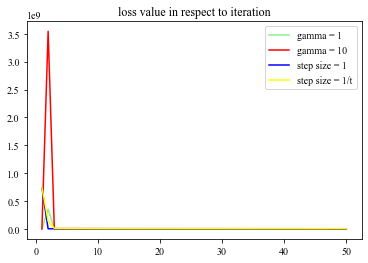

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)
x = np.linspace(1, 50, 50)
ax.plot(x, loss_1, color='lightgreen', label="gamma = 1")
ax.plot(x, loss_2, color='red', label="gamma = 10")
ax.plot(x, loss_3, color='blue', label="step size = 1")
ax.plot(x, loss_4, color='yellow', label="step size = 1/t")
ax.title.set_text("loss value in respect to iteration")
ax.legend()

In [19]:
def fit_LR_GD_5(Y, H, W0=None, sub_iter=100, stopping_diff=0.01, gamma = 1, delta = 1):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1)
            
        W1 = W0.copy()
        i = 0
        dist = 1
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - gamma * ((i+1)**(-delta)) * grad
            i = i + 1
            loss = 0
            j=0
            for j in np.arange(Y.shape[0]):   
                if H[:,j].T @ W1 > 100:
                    loss = H[:,j].T @ W1  + loss
                else:
                    loss = np.log(1+np.exp(H[:,j].T @ W1 )) + loss
            loss = loss - (Y.T@ H.T @W1)
            loss = loss[0,0]
            loss_list = np.append(loss_list, loss)
        return W1,loss_list

<ipython-input-19-fe19f5fe4f40>:11: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))


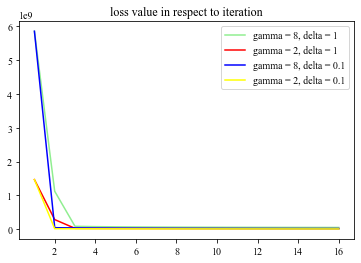

In [21]:
X_train, X_test, y_train, y_test = sample_binary_MNIST(['0', '1'], full_MNIST = [X,y])
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))

W5,loss_5 = fit_LR_GD_5(Y=y_train, H=H_train,sub_iter=16, gamma = 8, delta = 1) 
W6,loss_6 = fit_LR_GD_5(Y=y_train, H=H_train,sub_iter=16, gamma = 2, delta = 1) 
W7,loss_7 = fit_LR_GD_5(Y=y_train, H=H_train,sub_iter=16, gamma = 8, delta = 0.1) 
W8,loss_8 = fit_LR_GD_5(Y=y_train, H=H_train,sub_iter=16, gamma = 2, delta = 0.1)

fig, ax = plt.subplots(nrows=1, ncols=1)
x = np.linspace(1, 16, 16)
ax.plot(x, loss_5, color='lightgreen', label="gamma = 8, delta = 1")
ax.plot(x, loss_6, color='red', label="gamma = 2, delta = 1")
ax.plot(x, loss_7, color='blue', label="gamma = 8, delta = 0.1")
ax.plot(x, loss_8, color='yellow', label="gamma = 2, delta = 0.1")
ax.title.set_text("loss value in respect to iteration")
ax.legend()

In [24]:
from scipy.sparse.linalg import cg
def fit_LR_NR(Y, H, W0=None, sub_iter=20, stopping_diff=0.01, gamma = 1, delta = 1):
        if W0 is None:
            W0 = np.zeros((H.shape[0],1))
            
        W1 = W0.copy()
        i = 0
        dist = 1
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  
            diag_list = np.array([])
            
            for k in np.arange(Y.shape[0]):              
                p = Q[k,0]
                dia = p*(1-p)
                diag_list=np.append(diag_list, dia)
            
            D = np.diag(diag_list)
            
            Hessian = H@D@H.T
            grad = H @ (Q - Y)
            
            W1 = W1 - cg(Hessian,grad)[0].reshape(-1,1)
            i = i + 1
            
            loss = -Y.T@ H.T @W1
            for j in np.arange(Y.shape[0]):
                c = H[:,j].T @ W1
                if c > 100:
                    increment = c
                elif c > 0:
                    increment = c+ np.log(1+1/np.exp(c))
                else :
                    increment = np.log(1+np.exp(c))
                loss += increment
            loss_list = np.append(loss_list, loss)
        return W1,loss_list

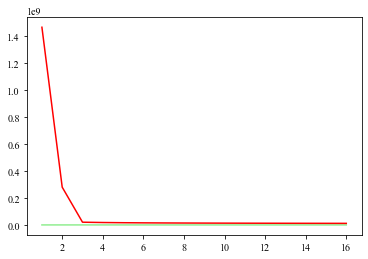

In [25]:
X_train, X_test, y_train, y_test = sample_binary_MNIST(['0', '1'], full_MNIST = [X,y])
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))

WNR,loss_NR = fit_LR_NR(Y=y_train, H=H_train,sub_iter=20)
fig, ax = plt.subplots(nrows=1, ncols=1)
x = np.linspace(1, 16, 16)
ax.plot(x, loss_NR, color='lightgreen', label="newton's method")
ax.plot(x, loss_6, color='red', label="gamma = 2, delta = 1")

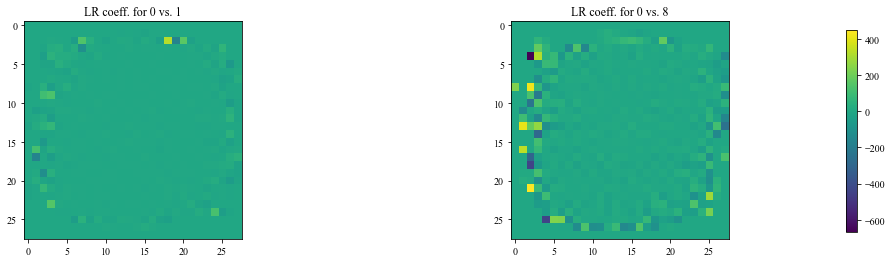

In [28]:
# plot fitted polynomial regression curve
digit_list_list = [['0','1'],['0','8']] # list of list of two digits
# fit LR for each cases
W_array = []
for i in np.arange(len(digit_list_list)):
    L = digit_list_list[i]
    X_train, X_test, y_train, y_test = sample_binary_MNIST(list_digits=L, full_MNIST = [X,y])
    H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 
    W, loss_list = fit_LR_NR(Y=y_train, H=H_train,sub_iter=100) 
    
    W_array.append(W.copy())

W_array = np.asarray(W_array)


# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(digit_list_list), figsize=[16, 4])
for i in np.arange(len(digit_list_list)):
    L = digit_list_list[i]
    W = W_array[i]
    im = ax[i].imshow(W[1:,:].reshape(28,28), vmin=np.min(W_array), vmax=np.max(W_array))
    ax[i].title.set_text("LR coeff. for %s vs. %s" % (L[0], L[1])) 
    # ax[i].legend()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('LR_MNIST_training_ex.pdf', bbox_inches='tight')